In [17]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix


In [18]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    

Using device: cuda


In [19]:
images_path = 'Data/BraTS2021'
IMG_SIZE = 128
VOLUME_SLICES = 50
VOLUME_START_AT = 22

# Load dataset
all_patients = [os.path.join(images_path, p) for p in os.listdir(images_path)]
np.random.shuffle(all_patients)

print(f"Total Patients Loaded: {len(all_patients)}")


Total Patients Loaded: 1251


In [20]:
nodes = {
    "Hospital_1": all_patients[:len(all_patients)//3],
    "Hospital_2": all_patients[len(all_patients)//3:2*len(all_patients)//3],
    "Hospital_3": all_patients[2*len(all_patients)//3:]
}

print(f"Total Patients per Hospital: {[len(nodes[h]) for h in nodes.keys()]}")


Total Patients per Hospital: [417, 417, 417]


In [21]:
class BraTSDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        case_path = os.path.join(images_path, os.path.basename(self.file_list[idx]), os.path.basename(self.file_list[idx]))

        flair = nib.load(f'{case_path}_flair.nii').get_fdata()
        ce = nib.load(f'{case_path}_t1ce.nii').get_fdata()
        seg = nib.load(f'{case_path}_seg.nii').get_fdata()

        flair = cv2.resize(flair[:, :, 22], (128, 128))
        ce = cv2.resize(ce[:, :, 22], (128, 128))
        seg = cv2.resize(seg[:, :, 22], (128, 128))

        # Ensure all labels are within the expected range [0,1,2,3]
        seg[seg == 4] = 3  # Map class 4 to 3

        image = np.stack([flair, ce], axis=0)
        label = seg.astype(np.int64)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [22]:
batch_size = 4
hospital_loaders = {}

train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

for hospital, files in nodes.items():
    dataset = BraTSDataset(files)
    
    # Compute dataset sizes
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # Perform split
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    # Create dataloaders
    hospital_loaders[hospital] = {
        "train": DataLoader(train_set, batch_size=batch_size, shuffle=True),
        "val": DataLoader(val_set, batch_size=batch_size, shuffle=False),
        "test": DataLoader(test_set, batch_size=batch_size, shuffle=False),
    }

    print(f"{hospital} - Train: {train_size}, Val: {val_size}, Test: {test_size}")


Hospital_1 - Train: 291, Val: 62, Test: 64
Hospital_2 - Train: 291, Val: 62, Test: 64
Hospital_3 - Train: 291, Val: 62, Test: 64


In [23]:
class UNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=4):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.decoder3(torch.cat([self.upconv3(b), e3], dim=1))
        d2 = self.decoder2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.decoder1(torch.cat([self.upconv1(d2), e1], dim=1))

        return self.final_conv(d1)


In [24]:
def federated_averaging(models):
    new_model = UNet().to(device)
    new_state_dict = new_model.state_dict()

    for key in new_state_dict.keys():
        new_state_dict[key] = torch.stack([models[i][key] for i in range(len(models))], dim=0).mean(dim=0)

    new_model.load_state_dict(new_state_dict)
    return new_model.state_dict()


In [25]:
global_model = UNet().to(device)
num_rounds = 3
learning_rate = 0.001

for round in range(num_rounds):
    local_weights = []

    for hospital, dataloader in hospital_loaders.items():
        print(f"Training {hospital} - Round {round+1}")

        model = UNet().to(device)
        model.load_state_dict(global_model.state_dict())

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_fn = nn.CrossEntropyLoss()

        model.train()
        for images, labels in dataloader["train"]:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        local_weights.append(model.state_dict())

    new_global_weights = federated_averaging(local_weights)
    global_model.load_state_dict(new_global_weights)


Training Hospital_1 - Round 1
Training Hospital_2 - Round 1
Training Hospital_3 - Round 1
Training Hospital_1 - Round 2
Training Hospital_2 - Round 2
Training Hospital_3 - Round 2
Training Hospital_1 - Round 3
Training Hospital_2 - Round 3
Training Hospital_3 - Round 3


In [26]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Computes Dice Score for segmentation."""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)


In [27]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Define tumor class labels
tumor_labels = ["Background", "Edema", "Enhancing Tumor", "Tumor Core"]

# Evaluate FL model
evaluation_results = {}

for hospital, data_loader in hospital_loaders.items():
    print(f"Evaluating models for {hospital}...")

    fl_preds, y_trues = [], []

    with torch.no_grad():
        for images, labels in data_loader["test"]:
            images, labels = images.to(device), labels.cpu().numpy()

            # FL Model Predictions
            fl_outputs = global_model(images).cpu().numpy()
            fl_preds.append(np.argmax(fl_outputs, axis=1))
            y_trues.append(labels)

    # Flatten predictions & ground truth
    y_true = np.concatenate(y_trues).flatten()
    y_pred_fl = np.concatenate(fl_preds).flatten()

    # Compute Dice Score
    dice_fl = dice_coefficient(y_true, y_pred_fl)

    # Compute Confusion Matrix
    cm_fl = confusion_matrix(y_true, y_pred_fl, labels=[0, 1, 2, 3])

    # Compute ROC-AUC Score
    fpr_fl, tpr_fl, _ = roc_curve(y_true.ravel(), y_pred_fl.ravel(), pos_label=1)
    auc_fl = auc(fpr_fl, tpr_fl)

    # Store results
    evaluation_results[hospital] = {
        "Dice FL": dice_fl,
        "AUC FL": auc_fl,
        "Confusion Matrix FL": cm_fl,
    }


Evaluating models for Hospital_1...
Evaluating models for Hospital_2...
Evaluating models for Hospital_3...


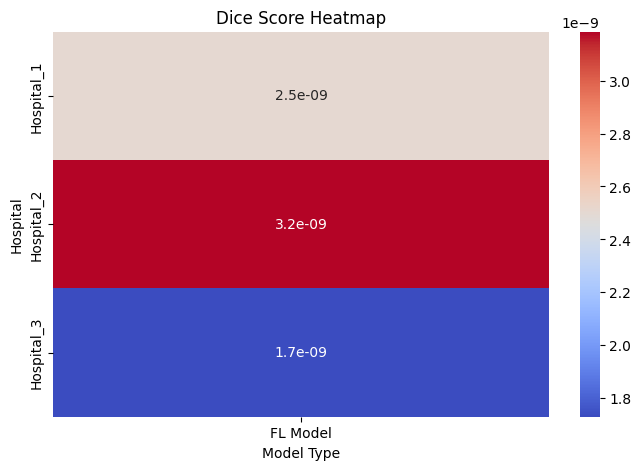

In [28]:
# Extract dice scores
dice_scores = np.array([[evaluation_results[h]["Dice FL"]] for h in hospital_loaders.keys()])

plt.figure(figsize=(8, 5))
sns.heatmap(dice_scores, annot=True, cmap="coolwarm", xticklabels=["FL Model"], yticklabels=list(hospital_loaders.keys()))
plt.title("Dice Score Heatmap")
plt.xlabel("Model Type")
plt.ylabel("Hospital")
plt.show()


Confusion Matrix for Hospital_1 - FL Model


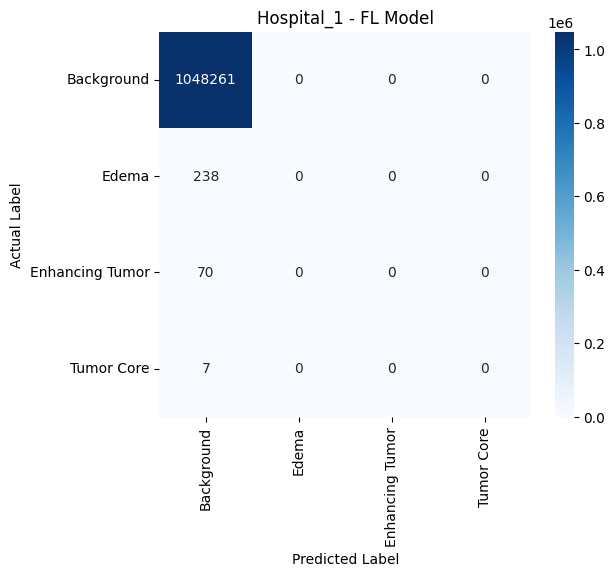

Confusion Matrix for Hospital_2 - FL Model


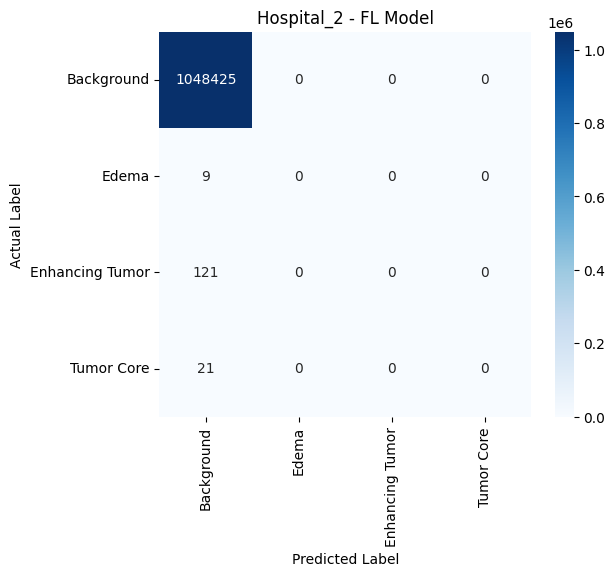

Confusion Matrix for Hospital_3 - FL Model


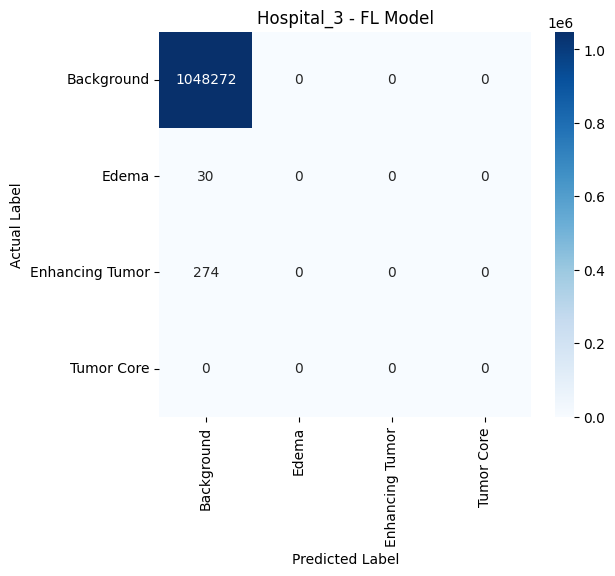

In [29]:
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tumor_labels, yticklabels=tumor_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()

for hospital in hospital_loaders.keys():
    print(f"Confusion Matrix for {hospital} - FL Model")
    plot_confusion_matrix(evaluation_results[hospital]["Confusion Matrix FL"], title=f"{hospital} - FL Model")


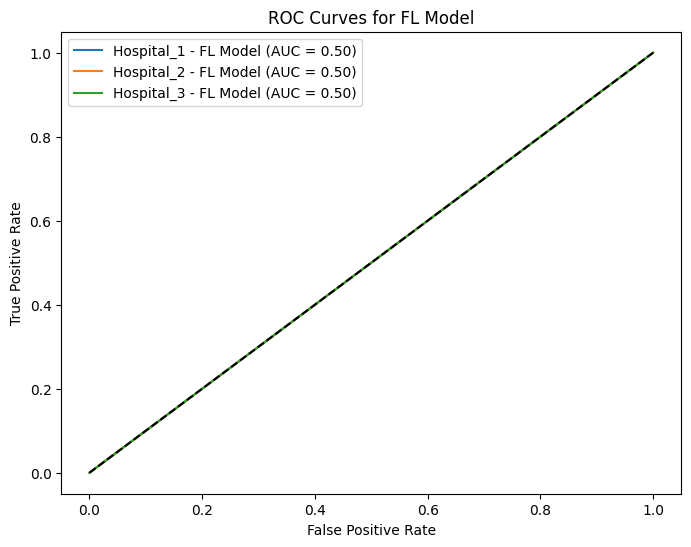

In [30]:
plt.figure(figsize=(8, 6))

for hospital in hospital_loaders.keys():
    fpr_fl, tpr_fl, _ = roc_curve(y_true.ravel(), y_pred_fl.ravel(), pos_label=1)
    auc_fl = evaluation_results[hospital]["AUC FL"]

    plt.plot(fpr_fl, tpr_fl, label=f"{hospital} - FL Model (AUC = {auc_fl:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for FL Model")
plt.legend()
plt.show()


In [31]:
def plot_tumor_overlay(image, ground_truth, prediction, title="Tumor Overlay"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image[0, :, :], cmap="gray")
    axes[0].set_title("FLAIR MRI")

    axes[1].imshow(ground_truth, cmap="jet", alpha=0.6)
    axes[1].set_title("Ground Truth")

    axes[2].imshow(prediction, cmap="jet", alpha=0.6)
    axes[2].set_title("Predicted Segmentation")

    plt.suptitle(title)
    plt.show()

# Select a sample patient from Hospital 1
sample_image, sample_label = next(iter(hospital_loaders["Hospital_1"]["test"]))
sample_image = sample_image[0].cpu().numpy()
sample_label = sample_label[0].cpu().numpy()

# Run FL Model
with torch.no_grad():
    fl_pred = global_model(sample_image.unsqueeze(0).to(device)).cpu().numpy().argmax(axis=1)[0]

# Plot FL Prediction
plot_tumor_overlay(sample_image, sample_label, fl_pred, title="FL Model Tumor Segmentation")


AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [34]:
import torch

# Clear cache (for GPU)
torch.cuda.empty_cache()

# Optional: if you're done with variables and want to ensure deletion
#del variable_name  # e.g., del model, del output, etc.
torch.cuda.empty_cache()

# If needed: collect unused memory
torch.cuda.ipc_collect()


In [35]:
import gc
import torch


gc.collect()

# Empty CUDA cache
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
